In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electrity-prices/electricity_prices.csv


**Goal of this notebook is to predict electricity prices using given features.**

1. Upload data and necessary libraries

In [2]:
import matplotlib as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = pd.read_csv('/kaggle/input/electrity-prices/electricity_prices.csv')
X_full = X.copy()
X.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (9,10,11,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,None,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.00,9.30,600.71,356.00,3159.60,54.32
1,01/11/2011 00:30,None,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.00,11.10,605.42,317.00,2973.01,54.23
2,01/11/2011 01:00,None,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.00,11.10,589.97,311.00,2834.00,54.23
3,01/11/2011 01:30,None,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.00,9.30,585.94,313.00,2725.99,53.47
4,01/11/2011 02:00,None,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.00,11.10,571.52,346.00,2655.64,39.87


Data set uploader has these explanations for the  features:
> Column Description:

    DateTime: String, defines date and time of sample
    Holiday: String, gives name of holiday if day is a bank holiday
    HolidayFlag: integer, 1 if day is a bank holiday, zero otherwise
    DayOfWeek: integer (0-6), 0 monday, day of week
    WeekOfYear: integer, running week within year of this date
    Day integer: day of the date
    Month integer: month of the date
    Year integer: year of the date
    PeriodOfDay integer: denotes half hour period of day (0-47)
    ForecastWindProduction: the forecasted wind production for this period
    SystemLoadEA: the national load forecast for this period
    SMPEA: the price forecast for this period
    ORKTemperature: the actual temperature measured at Cork airport
    ORKWindspeed: the actual windspeed measured at Cork airport
    CO2Intensity: the actual CO2 intensity in (g/kWh) for the electricity produced
    ActualWindProduction: the actual wind energy production for this period
    SystemLoadEP2: the actual national system load for this period
    SMPEP2: the actual price of this time period, the value to be forecasted

SMPEP2 is the value that we need to build model to predict

2. Look up info about this data set

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38014 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                38014 non-null  object
 1   Holiday                 38014 non-null  object
 2   HolidayFlag             38014 non-null  int64 
 3   DayOfWeek               38014 non-null  int64 
 4   WeekOfYear              38014 non-null  int64 
 5   Day                     38014 non-null  int64 
 6   Month                   38014 non-null  int64 
 7   Year                    38014 non-null  int64 
 8   PeriodOfDay             38014 non-null  int64 
 9   ForecastWindProduction  38014 non-null  object
 10  SystemLoadEA            38014 non-null  object
 11  SMPEA                   38014 non-null  object
 12  ORKTemperature          38014 non-null  object
 13  ORKWindspeed            38014 non-null  object
 14  CO2Intensity            38014 non-null  object
 15  Ac

If we try to apply numeric functions to certain columns e.g. SMPEP2, SMPEA etc. it will throw exception. It happens because Null values  shown as '?' instead of np.NaN. Let's fix that

In [4]:
X=X.replace('?', np.NaN)
X.isnull().sum()

DateTime                    0
Holiday                     0
HolidayFlag                 0
DayOfWeek                   0
WeekOfYear                  0
Day                         0
Month                       0
Year                        0
PeriodOfDay                 0
ForecastWindProduction      5
SystemLoadEA                2
SMPEA                       2
ORKTemperature            295
ORKWindspeed              299
CO2Intensity                7
ActualWindProduction        5
SystemLoadEP2               2
SMPEP2                      2
dtype: int64

As we can see there a few null values. Now we can change type of columns to numeric types

In [5]:
o_list=['ForecastWindProduction','SystemLoadEA','SMPEA', 'ORKTemperature',
'ORKWindspeed','CO2Intensity','ActualWindProduction','SystemLoadEP2', 'SMPEP2']
X[o_list]=X[o_list].apply(pd.to_numeric)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38014 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DateTime                38014 non-null  object 
 1   Holiday                 38014 non-null  object 
 2   HolidayFlag             38014 non-null  int64  
 3   DayOfWeek               38014 non-null  int64  
 4   WeekOfYear              38014 non-null  int64  
 5   Day                     38014 non-null  int64  
 6   Month                   38014 non-null  int64  
 7   Year                    38014 non-null  int64  
 8   PeriodOfDay             38014 non-null  int64  
 9   ForecastWindProduction  38009 non-null  float64
 10  SystemLoadEA            38012 non-null  float64
 11  SMPEA                   38012 non-null  float64
 12  ORKTemperature          37719 non-null  float64
 13  ORKWindspeed            37715 non-null  float64
 14  CO2Intensity            38007 non-null

3. Change DateTime column to datetime type

In [7]:
X['DateTime']=pd.to_datetime(X['DateTime'],dayfirst=True)

4. Because of small amount of rows with null values, so we can drop them

In [8]:
X=X.dropna()

In [9]:
X.isnull().sum()

DateTime                  0
Holiday                   0
HolidayFlag               0
DayOfWeek                 0
WeekOfYear                0
Day                       0
Month                     0
Year                      0
PeriodOfDay               0
ForecastWindProduction    0
SystemLoadEA              0
SMPEA                     0
ORKTemperature            0
ORKWindspeed              0
CO2Intensity              0
ActualWindProduction      0
SystemLoadEP2             0
SMPEP2                    0
dtype: int64

5. Exploratory data analysis. 

Lets plot graph of SMPEP2, column that we need to predict and SMPEA which is daily price prediction given daily

<AxesSubplot:xlabel='DateTime'>

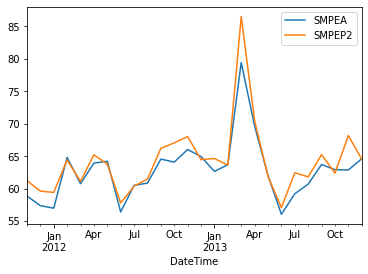

In [10]:
X_eda=X.set_index('DateTime')
X_eda[['SMPEA','SMPEP2']].resample('M').mean().plot()

There is a huge spike in price in february. Is there a possible outlier? Let's futher explore it through few scatter plots

<AxesSubplot:xlabel='WeekOfYear', ylabel='SMPEP2'>

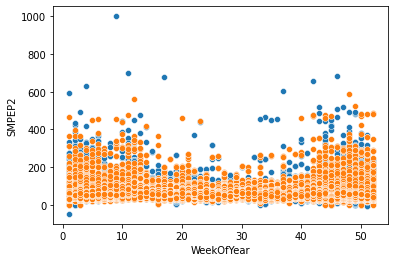

In [11]:
sns.scatterplot(data=X_eda, x='WeekOfYear', y='SMPEP2')
sns.scatterplot(data=X_eda, x='WeekOfYear', y='SMPEA')

<AxesSubplot:xlabel='PeriodOfDay', ylabel='SMPEP2'>

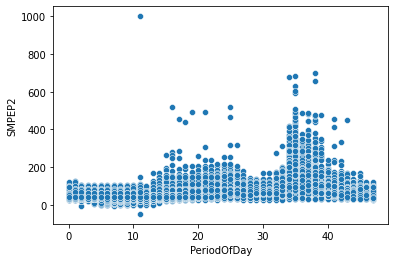

In [12]:
sns.scatterplot(data=X_eda, x='PeriodOfDay', y='SMPEP2')

From what we can see from scatterplots that these values are pretty closely related, and only one data entry sticks out.

In [13]:
X_eda.loc[X_eda.SMPEP2==1000.00]

,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
DateTime,,,,,,,,,,,,,,,,,
2013-02-26 05:30:00,None,0,1,9,26,2,2013,11,142.8,3370.41,44.18,1.0,13.0,580.92,86.0,3304.05,1000.0


It looks like this entry  is a mistake. So we will remove from model later

**6. Modelling. **

To process this dataset we need hot-encode our categorical columns. Let's use hot-encoding and pd.get_dummies

In [14]:
X.Holiday.nunique()
one_hot = pd.get_dummies(X['Holiday'])
X=X.drop('Holiday', axis=1)

Column 'Holiday' has been dropped, as it serves no purpose here.

In [15]:
one_hot.head()

,August Bank Holiday,Christmas,Christmas Eve,Easter,Easter Monday,Good Friday,Holy Saturday,June Bank Holiday,May Day,New Year's Day,New Year's Eve,None,October Bank Holiday,St Patrick's Day,St Stephen's Day
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Merging initial dataset and one-hot encoded holidays

In [16]:
X_merged=X.merge(one_hot, left_index=True, right_index=True)

In [17]:
X_merged.head()

,DateTime,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,...,Good Friday,Holy Saturday,June Bank Holiday,May Day,New Year's Day,New Year's Eve,None,October Bank Holiday,St Patrick's Day,St Stephen's Day
0,2011-11-01 00:00:00,0,1,44,1,11,2011,0,315.31,3388.77,...,0,0,0,0,0,0,1,0,0,0
1,2011-11-01 00:30:00,0,1,44,1,11,2011,1,321.80,3196.66,...,0,0,0,0,0,0,1,0,0,0
2,2011-11-01 01:00:00,0,1,44,1,11,2011,2,328.57,3060.71,...,0,0,0,0,0,0,1,0,0,0
3,2011-11-01 01:30:00,0,1,44,1,11,2011,3,335.60,2945.56,...,0,0,0,0,0,0,1,0,0,0
4,2011-11-01 02:00:00,0,1,44,1,11,2011,4,342.90,2849.34,...,0,0,0,0,0,0,1,0,0,0


In [18]:
X_merged.loc[X_merged.SMPEP2==1000.00]

,DateTime,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,...,Good Friday,Holy Saturday,June Bank Holiday,May Day,New Year's Day,New Year's Eve,None,October Bank Holiday,St Patrick's Day,St Stephen's Day
23193,2013-02-26 05:30:00,0,1,9,26,2,2013,11,142.8,3370.41,...,0,0,0,0,0,0,1,0,0,0


Drop SMPEP2 extreme outlier.

In [19]:
X_merged=X_merged.drop([23193])

Also lets drop day, month, holidayflag columns because of their redundancy

In [20]:
X_merged=X_merged.drop(['Day', 'Month', 'HolidayFlag'], axis=1)

X_merged.head()

,DateTime,DayOfWeek,WeekOfYear,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,...,Good Friday,Holy Saturday,June Bank Holiday,May Day,New Year's Day,New Year's Eve,None,October Bank Holiday,St Patrick's Day,St Stephen's Day
0,2011-11-01 00:00:00,1,44,2011,0,315.31,3388.77,49.26,6.0,9.3,...,0,0,0,0,0,0,1,0,0,0
1,2011-11-01 00:30:00,1,44,2011,1,321.80,3196.66,49.26,6.0,11.1,...,0,0,0,0,0,0,1,0,0,0
2,2011-11-01 01:00:00,1,44,2011,2,328.57,3060.71,49.10,5.0,11.1,...,0,0,0,0,0,0,1,0,0,0
3,2011-11-01 01:30:00,1,44,2011,3,335.60,2945.56,48.04,6.0,9.3,...,0,0,0,0,0,0,1,0,0,0
4,2011-11-01 02:00:00,1,44,2011,4,342.90,2849.34,33.75,6.0,11.1,...,0,0,0,0,0,0,1,0,0,0


7. Model Building  

Let's start from finding out which parameters affect our y.

In [21]:
corr_data=X_merged.corr()[['SMPEP2']].sort_values(by='SMPEP2', ascending=False)

In [22]:
corr_data.head(10)

,SMPEP2
SMPEP2,1.000000
SMPEA,0.624370
SystemLoadEP2,0.522343
SystemLoadEA,0.496245
PeriodOfDay,0.327169
Year,0.045188
Easter,0.015367
St Patrick's Day,0.013117
Good Friday,0.011391
May Day,0.004900


As we can see SMPEA (price prediction) is the most correlated with actual price, System load is also good predictor

In [23]:
y=X_merged.SMPEP2

Firstly, we will build our model with only highly correlated parameters, after that we will encorporate all of the parameters.
Our model building flow will be:
only highly correlated features: XGB -> XGB(tuned) -> RFR
all the data: XGB -> XGB(tuned) -> RFR
for every model we will calculate mean absolute error

In [24]:
X_clean=X_merged[['SMPEA','SystemLoadEP2','SystemLoadEA', 'PeriodOfDay']]

split our model into validation set and training set

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_clean, y)

First, we will use XBG algorithm to make a price predicting model

In [26]:
my_model = XGBRegressor(random_state=63)
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=63,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
predictions = my_model.predict(X_valid)

Calculate mean absolute error of the model

In [28]:
mae_XBG=mean_absolute_error(predictions,y_valid)
mean_y=X_merged.SMPEP2.mean()

In [29]:
print("Mean Absolute Error: " + str(mae_XBG))
print('prediction accuracy: ' +str(1-mae_XBG/mean_y))

Mean Absolute Error: 13.37367326230105
prediction accuracy: 0.7915461181224545


As we can see MAE equals 13.53. Lets we can tune it to lesser MAE

In [30]:
my_model_tuned= XGBRegressor(n_estimators=600, learning_rate=0.05)
my_model_tuned.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
predictions_2=my_model_tuned.predict(X_valid)

In [32]:
mae_XBG2=mean_absolute_error(predictions_2,y_valid)
mean_y=X_merged.SMPEP2.mean()
print("Mean Absolute Error: " + str(mae_XBG2))
print('prediction accuracy: ' +str(1-mae_XBG2/mean_y))

Mean Absolute Error: 13.209479273439857
prediction accuracy: 0.7941053906340356


Now we will use Random Forest regression model.

In [33]:
forest_model = RandomForestRegressor(random_state=63)
forest_model.fit(X_train, y_train)
fores_preds = forest_model.predict(X_valid)
forest_mae=mean_absolute_error(y_valid, fores_preds)
print("Mean Absolute Error: " + str(forest_mae))
print('prediction accuracy: ' +str(1-forest_mae/mean_y))

Mean Absolute Error: 12.420901241906378
prediction accuracy: 0.8063968642338791


In [34]:
X_v2=X_merged.drop(['SMPEP2','DateTime'],axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_v2, y)
model_XGB_full= XGBRegressor(random_state=63)
model_XGB_full.fit(X_train, y_train)
predictions_3= model_XGB_full.predict(X_valid)

In [35]:
mae_XBG3=mean_absolute_error(predictions_3,y_valid)
mean_y=X_merged.SMPEP2.mean()
print("Mean Absolute Error: " + str(mae_XBG3))
print('prediction accuracy: ' +str((mean_y-mae_XBG3)/mean_y))

Mean Absolute Error: 11.422052940645612
prediction accuracy: 0.8219657959492614


In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X_v2, y)
forest_model_full = RandomForestRegressor(random_state=63)
forest_model_full.fit(X_train, y_train)
forest_model_full.fit(X_train, y_train)
predictions_fmf= forest_model_full.predict(X_valid)

In [37]:
fmf_mae=mean_absolute_error(y_valid, predictions_fmf)
print("Mean Absolute Error: " + str(fmf_mae))
print('prediction accuracy: ' +str(1-fmf_mae/mean_y))

Mean Absolute Error: 9.397759515974949
prediction accuracy: 0.8535182209379355


As we can see the most accurate model is Random Forest Regression used on full dataset.